In [ ]:
from keras.constraints import Constraint
import keras
import keras.backend as K
from math import sqrt
from keras.layers import Input, Dense, Reshape, Dropout, Conv2D, MaxPooling2D, Flatten, Conv2DTranspose 
from keras.layers import BatchNormalization ,Activation , UpSampling2D
from keras.models import Model 
from keras.initializers import RandomNormal
from keras.datasets import cifar10
import numpy as np 


Using TensorFlow backend.


In [ ]:
|input_shape = (32,32,3)
maps = [128,64,32,16] 
hidden = 256 
dropout = .2
memsize = 30
slotsize = 256
batch_size = 128

In [ ]:
#encoder
input_img = Input(shape=(32, 32, 3))
x = Conv2D(maps[0], (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(maps[1], (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(maps[2], (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
input_feature = Input(shape=(4, 4, maps[2]))
x = Conv2D(maps[2], (3, 3), padding='same')(input_feature)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(maps[1], (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(maps[0], (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

encoder = Model(input_img, encoded, name='encoder')
decoder = Model(input_feature, decoded, name='decoder')
decoded_img = decoder(encoder(input_img))
autoencoder = Model(input_img, decoded_img)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 4, 4, 32)          96736     
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         105967    
Total params: 202,703
Trainable params: 201,801
Non-trainable params: 902
_________________________________________________________________


In [ ]:
#denoise encoder
input_noisy = Input(shape=input_shape)
encoded = encoder(input_noisy)
image = decoder(encoded)
denoise_encoder = Model(inputs=input_noisy, outputs=encoded)
autoencoder_denosing = Model(inputs=input_noisy,outputs=[encoded,image])
autoencoder_denosing.compile(optimizer='adadelta', loss={'encoder':'mse', 'decoder':'binary_crossentropy'})
autoencoder_denosing.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              (None, 4, 4, 32)          96736     
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         105967    
Total params: 202,703
Trainable params: 201,801
Non-trainable params: 902
_________________________________________________________________


In [ ]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) =cifar10.load_data()
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 32 ,32, 3)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 32 ,32, 3)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255
y_train_mnist = keras.utils.to_categorical(y_train_mnist, 10)
y_test_mnist = keras.utils.to_categorical(y_test_mnist, 10)

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
noise_factor = 0.1
x_train_noisy = x_train_mnist + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train_mnist.shape)
x_test_noisy = x_test_mnist + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test_mnist.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
hist = autoencoder.fit(x_train_mnist,x_train_mnist,batch_size=batch_size,epochs=100,validation_data=[x_test_mnist,x_test_mnist])
autoencoder.save_weights('autoencoder.h5')

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
25728/50000 [==============>...............] - ETA: 21s - loss: 0.5956

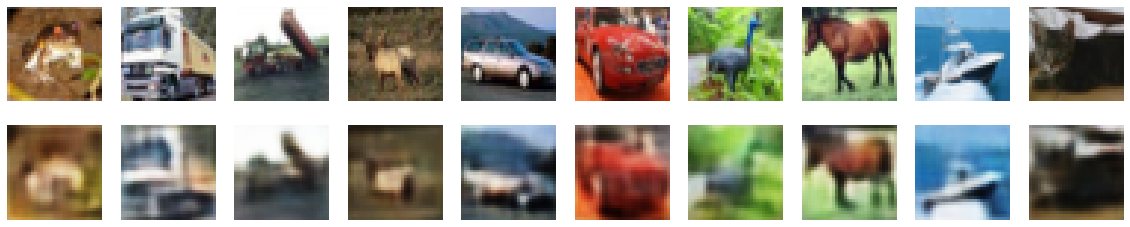

In [ ]:
showOrigDec(x_train_mnist, autoencoder.predict(x_train_mnist))

In [ ]:
targets_train = encoder.predict(x_train_mnist)
targets_test = encoder.predict(x_test_mnist)

In [ ]:
hist = autoencoder_denosing.fit(x_train_noisy,[targets_train,x_train_mnist],batch_size=batch_size,epochs=20,validation_data=[x_test_noisy,[targets_test,x_test_mnist]])
autoencoder_denosing.save_weights('ltmn_autoenocder')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 44s 890us/step - loss: 0.5768 - encoder_loss: 0.0133 - decoder_loss: 0.5635 - val_loss: 0.5783 - val_encoder_loss: 0.0124 - val_decoder_loss: 0.5659
Epoch 2/20
 9728/50000 [====>.........................] - ETA: 32s - loss: 0.5747 - encoder_loss: 0.0108 - decoder_loss: 0.5639

50000/50000 [==============================] - 43s 866us/step - loss: 0.5736 - encoder_loss: 0.0106 - decoder_loss: 0.5630 - val_loss: 0.5737 - val_encoder_loss: 0.0100 - val_decoder_loss: 0.5637
Epoch 3/20
24192/50000 [=============>................] - ETA: 21s - loss: 0.5726 - encoder_loss: 0.0100 - decoder_loss: 0.5626

50000/50000 [==============================] - 44s 870us/step - loss: 0.5728 - encoder_loss: 0.0099 - decoder_loss: 0.5629 - val_loss: 0.5721 - val_encoder_loss: 0.0089 - val_decoder_loss: 0.5633
Epoch 4/20
29952/50000 [================>.............] - ETA: 16s - loss: 0.5721 - encoder_loss: 0.0094 - decoder_loss: 0.5627

50000/50000 [==============================] - 43s 866us/step - loss: 0.5722 - encoder_loss: 0.0094 - decoder_loss: 0.5628 - val_loss: 0.5768 - val_encoder_loss: 0.0130 - val_decoder_loss: 0.5638
Epoch 5/20
32128/50000 [==================>...........] - ETA: 14s - loss: 0.5722 - encoder_loss: 0.0092 - decoder_loss: 0.5629

50000/50000 [==============================] - 43s 867us/step - loss: 0.5719 - encoder_loss: 0.0092 - decoder_loss: 0.5627 - val_loss: 0.5717 - val_encoder_loss: 0.0085 - val_decoder_loss: 0.5633
Epoch 6/20
33152/50000 [==================>...........] - ETA: 13s - loss: 0.5722 - encoder_loss: 0.0091 - decoder_loss: 0.5630

50000/50000 [==============================] - 44s 876us/step - loss: 0.5718 - encoder_loss: 0.0091 - decoder_loss: 0.5627 - val_loss: 0.5755 - val_encoder_loss: 0.0113 - val_decoder_loss: 0.5642
Epoch 7/20
33280/50000 [==================>...........] - ETA: 13s - loss: 0.5717 - encoder_loss: 0.0089 - decoder_loss: 0.5627

50000/50000 [==============================] - 43s 870us/step - loss: 0.5715 - encoder_loss: 0.0089 - decoder_loss: 0.5626 - val_loss: 0.5722 - val_encoder_loss: 0.0085 - val_decoder_loss: 0.5636
Epoch 8/20
32640/50000 [==================>...........] - ETA: 14s - loss: 0.5713 - encoder_loss: 0.0088 - decoder_loss: 0.5625

50000/50000 [==============================] - 43s 863us/step - loss: 0.5713 - encoder_loss: 0.0088 - decoder_loss: 0.5625 - val_loss: 0.5709 - val_encoder_loss: 0.0078 - val_decoder_loss: 0.5631
Epoch 9/20
32640/50000 [==================>...........] - ETA: 14s - loss: 0.5712 - encoder_loss: 0.0087 - decoder_loss: 0.5626

50000/50000 [==============================] - 43s 869us/step - loss: 0.5712 - encoder_loss: 0.0087 - decoder_loss: 0.5625 - val_loss: 0.5721 - val_encoder_loss: 0.0084 - val_decoder_loss: 0.5636
Epoch 10/20
33024/50000 [==================>...........] - ETA: 13s - loss: 0.5712 - encoder_loss: 0.0088 - decoder_loss: 0.5625

50000/50000 [==============================] - 43s 869us/step - loss: 0.5713 - encoder_loss: 0.0087 - decoder_loss: 0.5625 - val_loss: 0.5713 - val_encoder_loss: 0.0082 - val_decoder_loss: 0.5631
Epoch 11/20
33152/50000 [==================>...........] - ETA: 13s - loss: 0.5710 - encoder_loss: 0.0087 - decoder_loss: 0.5623

50000/50000 [==============================] - 43s 866us/step - loss: 0.5712 - encoder_loss: 0.0087 - decoder_loss: 0.5625 - val_loss: 0.5716 - val_encoder_loss: 0.0085 - val_decoder_loss: 0.5630
Epoch 12/20
33024/50000 [==================>...........] - ETA: 13s - loss: 0.5707 - encoder_loss: 0.0086 - decoder_loss: 0.5621

50000/50000 [==============================] - 43s 867us/step - loss: 0.5710 - encoder_loss: 0.0086 - decoder_loss: 0.5624 - val_loss: 0.5711 - val_encoder_loss: 0.0079 - val_decoder_loss: 0.5632
Epoch 13/20
33152/50000 [==================>...........] - ETA: 13s - loss: 0.5705 - encoder_loss: 0.0087 - decoder_loss: 0.5619

50000/50000 [==============================] - 44s 872us/step - loss: 0.5710 - encoder_loss: 0.0086 - decoder_loss: 0.5624 - val_loss: 0.5711 - val_encoder_loss: 0.0081 - val_decoder_loss: 0.5629
Epoch 14/20
33152/50000 [==================>...........] - ETA: 13s - loss: 0.5713 - encoder_loss: 0.0085 - decoder_loss: 0.5628

50000/50000 [==============================] - 43s 867us/step - loss: 0.5709 - encoder_loss: 0.0085 - decoder_loss: 0.5624 - val_loss: 0.5722 - val_encoder_loss: 0.0081 - val_decoder_loss: 0.5641
Epoch 15/20
32512/50000 [==================>...........] - ETA: 14s - loss: 0.5706 - encoder_loss: 0.0085 - decoder_loss: 0.5621

50000/50000 [==============================] - 43s 869us/step - loss: 0.5708 - encoder_loss: 0.0085 - decoder_loss: 0.5623 - val_loss: 0.5724 - val_encoder_loss: 0.0092 - val_decoder_loss: 0.5632
Epoch 16/20
32640/50000 [==================>...........] - ETA: 14s - loss: 0.5712 - encoder_loss: 0.0085 - decoder_loss: 0.5627

50000/50000 [==============================] - 44s 873us/step - loss: 0.5709 - encoder_loss: 0.0086 - decoder_loss: 0.5624 - val_loss: 0.5708 - val_encoder_loss: 0.0078 - val_decoder_loss: 0.5630
Epoch 17/20
32768/50000 [==================>...........] - ETA: 14s - loss: 0.5709 - encoder_loss: 0.0084 - decoder_loss: 0.5624

50000/50000 [==============================] - 43s 867us/step - loss: 0.5708 - encoder_loss: 0.0085 - decoder_loss: 0.5623 - val_loss: 0.5707 - val_encoder_loss: 0.0078 - val_decoder_loss: 0.5629
Epoch 18/20
32640/50000 [==================>...........] - ETA: 14s - loss: 0.5703 - encoder_loss: 0.0084 - decoder_loss: 0.5619

50000/50000 [==============================] - 43s 865us/step - loss: 0.5708 - encoder_loss: 0.0085 - decoder_loss: 0.5623 - val_loss: 0.5715 - val_encoder_loss: 0.0082 - val_decoder_loss: 0.5633
Epoch 19/20
32896/50000 [==================>...........] - ETA: 13s - loss: 0.5706 - encoder_loss: 0.0084 - decoder_loss: 0.5622

50000/50000 [==============================] - 44s 872us/step - loss: 0.5707 - encoder_loss: 0.0084 - decoder_loss: 0.5623 - val_loss: 0.5702 - val_encoder_loss: 0.0074 - val_decoder_loss: 0.5627
Epoch 20/20
32896/50000 [==================>...........] - ETA: 13s - loss: 0.5706 - encoder_loss: 0.0084 - decoder_loss: 0.5622

50000/50000 [==============================] - 43s 868us/step - loss: 0.5706 - encoder_loss: 0.0084 - decoder_loss: 0.5622 - val_loss: 0.5705 - val_encoder_loss: 0.0077 - val_decoder_loss: 0.5628


In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.rcParams[figure.figsize] = [10,10],
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

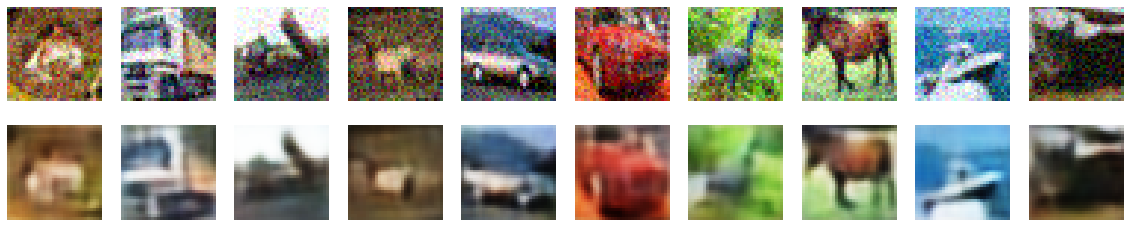

In [ ]:
images = autoencoder_denosing.predict(x_train_noisy)[1]
showOrigDec(x_train_noisy,images)

In [ ]:
for layer in denoise_encoder.layers:
    if layer.name == 'Memory':
        plt.imshow(layer.get_weights()[0].reshape(memsize,slotsize)[10].reshape(16,16), cmap='gray')
        break

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'ltmn_autoencoder'})
uploaded.SetContentFile('ltmn_autoencoder')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:
def build_memory_on_batch_mnist(full_memory=False, max_steps=10):
    sample_begin = 0
    sample_end = 10000
    mem_input = np.zeros((memsize, slotsize))
    new_input_shape = (1,) + x_test_mnist[0].shape
    label = 0
    for i in range(memsize):
        if (i + 1) % 3 == 0:
            label += 1
        index = np.random.randint(sample_begin, sample_end)
        while np.argmax(y_test_mnist[index]) != label and label != 10:
            index = np.random.randint(sample_begin, sample_end)
        # if np.random.rand() <= 0.1:
        #    continue
        mem_input[i] = encoder.predict(x_test_mnist[index].reshape(new_input_shape))[0]

    return mem_input